 # [Module 2.3] CatBoost 훈련 및 추론

이 노트북은 아래와 같은 작업을 합니다.
- 훈련, 검증 데이터 로딩
- Category 인덱스 추출
- CatBoost 훈련
- 테스트 데이터 로딩 및 추론
- 모델 평가
- 피쳐 Importance 생성

In [1]:
import pandas as pd

In [2]:
%store -r pre_train_file
%store -r pre_val_file
%store -r pre_test_file

## 훈련, 검증 데이터 세트 로딩

In [3]:
train_df = pd.read_csv(pre_train_file, header=None, skiprows=1)
val_df = pd.read_csv(pre_val_file, header=None, skiprows=1)

In [4]:
from IPython.display import display
display(train_df.head())
display(val_df.head())

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,2,10396,2730,26,69.90,14.25,400.0,21.0,16.0,16.0,...,151,14,5,10,3,319,21167,53046,3.898432,1.898432
1,1,10808,1381,26,359.90,14.42,15700.0,42.0,33.0,42.0,...,475,21,5,13,4,326,10329,54902,3.898432,2.898432
2,4,8243,2902,6,169.00,26.46,250.0,16.0,2.0,11.0,...,475,21,5,17,11,55,22636,44761,11.740230,7.740230
3,1,3813,336,11,179.00,17.96,2841.0,40.0,23.0,26.0,...,196,5,4,10,5,118,2309,25678,66.759373,65.759373
4,3,325,2699,26,115.98,20.00,600.0,19.0,17.0,18.0,...,123,18,6,18,8,323,20664,2628,4.988834,1.988834


,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,3,11313,2560,24,78.0,15.65,250.0,16.0,2.0,20.0,...,475,21,6,23,6,295,19335,57212,217.272977,214.272977
1,2,10229,851,18,16.9,12.48,410.0,39.0,3.0,28.0,...,11,14,1,15,5,216,6290,51673,55.971291,53.971291
2,4,6234,1301,5,49.3,22.28,250.0,20.0,8.0,11.0,...,475,21,4,26,7,40,9595,37568,5.988834,1.988834
3,1,4363,2357,11,22.0,15.23,225.0,21.0,11.0,16.0,...,475,21,2,5,6,132,17637,28692,2.988834,1.988834
4,2,3755,336,11,179.9,24.25,5050.0,62.0,6.0,55.0,...,318,7,3,13,6,120,2364,25018,6.898432,4.898432


In [5]:
X_train, y_train = train_df.iloc[:,1:], train_df.iloc[:,0]
X_val, y_val = val_df.iloc[:,1:], val_df.iloc[:,0]

## 레이블 인코딩된 category 인덱스 추출
- CatBoost 알고리즘에 category 인덱스를 알려 주기 위해서 임

In [6]:
cat_features_index = (X_train.dtypes == 'int64').index.tolist()
cat_features_index = [num -1 for num in cat_features_index]
cat_features_index

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

## CatBoost 훈련


In [7]:
%%time 

import catboost as cb
# cat_features_index = [] # customer_state, product_category_name_english, seller_state
# cat_features_index = [0,7,8,9] # customer_state, product_category_name_english, seller_state

clf = cb.CatBoostClassifier(eval_metric="Accuracy",max_depth=5,
                           iterations = 500)
clf.fit(X_train, y_train, verbose=False)


CPU times: user 2min 45s, sys: 2.21 s, total: 2min 48s
Wall time: 5 s


In [8]:
clf.score(X_val, y_val)

0.902270189802754

## Train 과 Val를 합쳐서 훈련 (Train_Val)

In [9]:
# def concatenate_train_val(X_train, y_train, X_val, y_val):
#     X_train_val = pd.concat([X_train, X_val], axis=0)
#     print("X_train_val: ", X_train_val.shape)
#     y_train_val = pd.concat([y_train, y_val], axis=0)    
#     print("y_train_val: ", y_train_val.shape)    
    
#     return X_train_val, y_train_val

# X_train_val, y_train_val = concatenate_train_val(X_train, y_train, X_val, y_val)
# clf = cb.CatBoostClassifier(eval_metric="Accuracy",max_depth=5,
#                            iterations = 500)
# clf.fit(X_train_val, y_train_val, verbose=False)



## Test 데이터로 평가

In [10]:
test_df = pd.read_csv(pre_test_file, header=None,skiprows=1)
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,1,511,240,26,35.00,8.41,350.0,21.0,9.0,13.0,...,475,21,2,26,6,326,1429,3682,6.815892,5.815892
1,3,8275,2914,17,21.99,22.85,300.0,17.0,4.0,12.0,...,475,21,6,12,5,203,22830,44880,21.546871,18.546871
2,3,5185,2056,11,69.90,18.59,125.0,20.0,16.0,19.0,...,207,21,7,5,8,132,15423,32883,20.265622,17.265622
3,2,9025,411,7,284.90,18.29,610.0,18.0,12.0,18.0,...,117,14,1,25,6,65,3093,48009,6.898432,4.898432
4,2,321,2699,26,129.90,12.30,1700.0,30.0,35.0,25.0,...,99,21,5,5,5,326,20657,2534,68.788029,66.788029


In [11]:
X_test, y_test = test_df.iloc[:,1:], test_df.iloc[:,0]

In [12]:
prediction = clf.predict(X_test)

## 모델 평가

In [13]:
from sklearn.metrics import accuracy_score, f1_score
accuracy = accuracy_score(y_test, prediction)
f1_score = f1_score(y_test, prediction, average='macro')
print("accuracy: %.2f%%" % accuracy)
print("f1_score: %.2f%%" % f1_score)

accuracy: 0.90%
f1_score: 0.89%


[[ 517   95   18    1    0]
 [  19 1382  108   15    3]
 [   2   42 2049   48    8]
 [   2   12  116 1441   27]
 [   1    8   43  102  659]]


<Figure size 432x288 with 0 Axes>

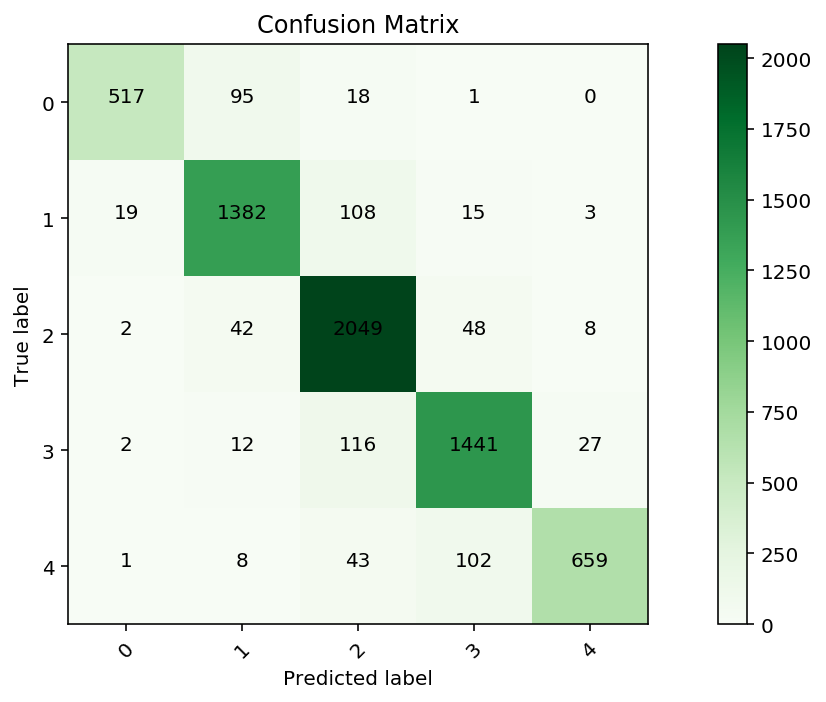

In [14]:
from utils import plot_conf_mat


from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

cm = confusion_matrix(y_true= y_test, y_pred= prediction)

plt.figure()
fig, ax = plt.subplots(figsize=(10,5))
plot_conf_mat(cm, 
              classes=['0','1', '2', '3', '4'], 
              title='Confusion Matrix')
plt.show()

## Feature Importance

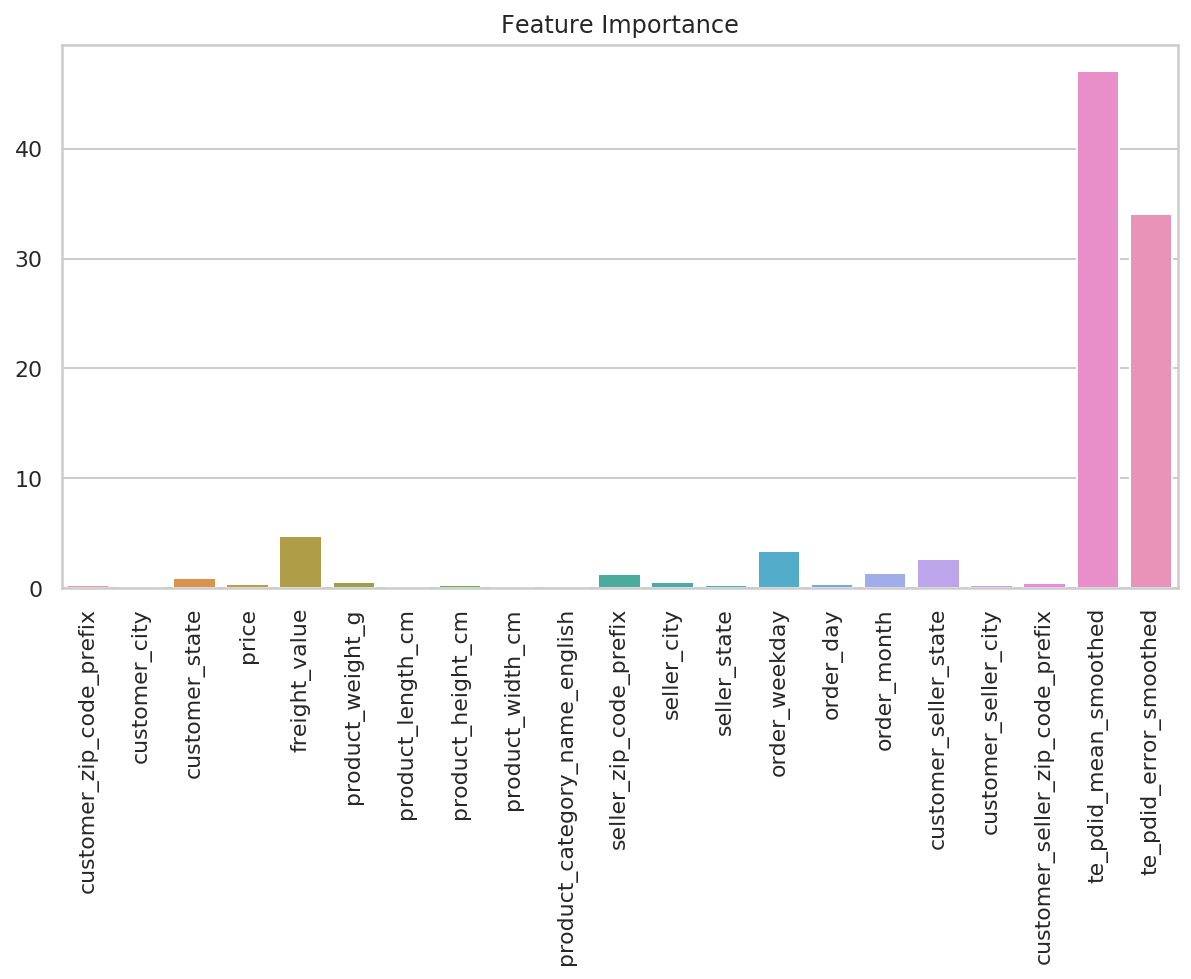

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")


test_col_df = pd.read_csv(pre_test_file)
features = test_col_df.columns[1:]
fea_importance = clf.feature_importances_

f, ax = plt.subplots(figsize=(10,5))
plot = sns.barplot(x=features, y= fea_importance)
ax.set_title('Feature Importance')
plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')
plt.show()